<a href="https://colab.research.google.com/github/bjg5091/Capstone-3-COVID-Image-Processing/blob/main/Notebooks/Capstone_3_Modeling_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.color
import skimage.filters
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

#data = pd.read_csv('metadata.csv')

from google.colab import files
#uploaded = files.upload()

print(tf.__version__)

2.12.0


In [ ]:
import io
#data = pd.read_csv(io.BytesIO(uploaded['metadata.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#data.head()

In [ ]:
#data.shape

In [ ]:
#data['label'].value_counts()

In [ ]:
import cv2
import glob
from skimage.filters import gaussian
from skimage import img_as_ubyte
from google.colab import drive
drive.mount('RadiographyDataset/')

Drive already mounted at RadiographyDataset/; to attempt to forcibly remount, call drive.mount("RadiographyDataset/", force_remount=True).


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/RadiographyDataset/MyDrive/RadiographyDataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
cwd = os.getcwd()
print(cwd)

/content


In [ ]:
import pathlib

image_list = []
path = '/tmp/RadiographyDataset/RadiographyDataset'
data_dir = pathlib.Path(path).with_suffix('')
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

/tmp/RadiographyDataset/RadiographyDataset
21165


In [ ]:
image_list = []
path_covid = '/tmp/RadiographyDataset/RadiographyDataset/COVID/*.*'

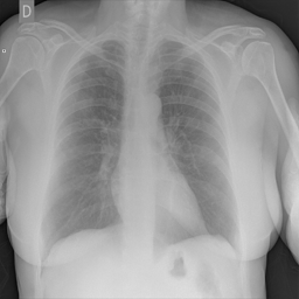

In [ ]:
covid = list(data_dir.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

In [ ]:
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
imagePaths = []
for dirname, _, filenames in os.walk('/tmp/RadiographyDataset/RadiographyDataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [ ]:
imagePaths

['/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-4164.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-7052.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-5974.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-1108.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-5948.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-6923.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-5040.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-1967.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-6421.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-3469.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-3640.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-8343.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-7974.png',
 '/tmp/RadiographyDataset/RadiographyDataset/Normal/Normal-5094.png',
 '/tmp/RadiographyDa

In [ ]:
#Data = []
#Target = []
#resize = 60

#cat = {'Viral_Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19', 'Lung_Opacity': 'Lung_Opacity'}

In [ ]:
#for imagePath in tqdm(imagePaths):
#    label = imagePath.split(os.path.sep)[-2]
#    image = cv2.imread(imagePath)
#    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#    image = cv2.resize(image, (resize, resize)) /255

#    Data.append(image)
#    Target.append(cat[label])

In [ ]:
#le = LabelEncoder()
#labels = le.fit_transform(Target)
#labels = to_categorical(labels)

#print(le.classes_)
#print(labels[0])

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.65,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 7408 files for training.


In [ ]:
#y_train = np.concatenate([y for x, y in train_ds], axis=0)

In [ ]:
#train_labels=[]
#train_images=[]
#for images, labels in train_ds.unbatch():
#    train_images.append(images)
#    train_labels.append(labels.numpy().argmax()) # or labels.numpy().argmax() for int labels

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  label_mode='categorical',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 3174 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 80
Number of test batches: 20


In [ ]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


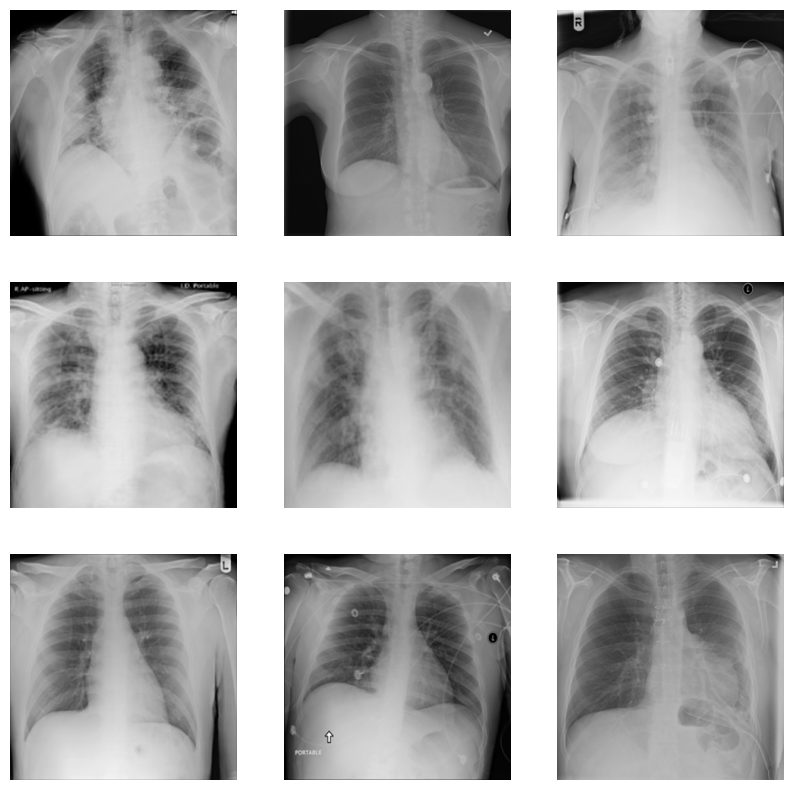

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32, 4)


In [ ]:
from PIL import Image
import random 
imsize = (299,299)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.73333335


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from keras.applications.vgg16 import preprocess_input

preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = imsize + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 9, 9, 512)


In [ ]:
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
base_learning_rate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
initial_epochs = 15

In [ ]:
this_model = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs, batch_size=128, verbose=1, callbacks = [es])

Epoch 1/15


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


232/232 [==============================] - 108s 429ms/step - loss: 1.9318 - accuracy: 0.4387 - val_loss: 1.1754 - val_accuracy: 0.5880
Epoch 2/15
232/232 [==============================] - 91s 395ms/step - loss: 1.4237 - accuracy: 0.5418 - val_loss: 0.9397 - val_accuracy: 0.6527
Epoch 3/15
232/232 [==============================] - 92s 395ms/step - loss: 1.2027 - accuracy: 0.6069 - val_loss: 0.8137 - val_accuracy: 0.6997
Epoch 4/15
232/232 [==============================] - 91s 394ms/step - loss: 1.0719 - accuracy: 0.6392 - val_loss: 0.7419 - val_accuracy: 0.7277
Epoch 5/15
232/232 [==============================] - 91s 393ms/step - loss: 0.9697 - accuracy: 0.6724 - val_loss: 0.6830 - val_accuracy: 0.7522
Epoch 6/15
232/232 [==============================] - 91s 394ms/step - loss: 0.8848 - accuracy: 0.6837 - val_loss: 0.6434 - val_accuracy: 0.7687
Epoch 7/15
232/232 [==============================] - 91s 393ms/step - loss: 0.8185 - accuracy: 0.7048 - val_loss: 0.6101 - val_accuracy: 0.

In [ ]:
accuracy = this_model.history['accuracy']
val_accuracy = this_model.history['val_accuracy']
loss = this_model.history['loss']
val_loss = this_model.history['val_loss']

print(np.max(val_accuracy))

0.8307024240493774


In [ ]:
epoch_range = range(1, len(accuracy)+1)

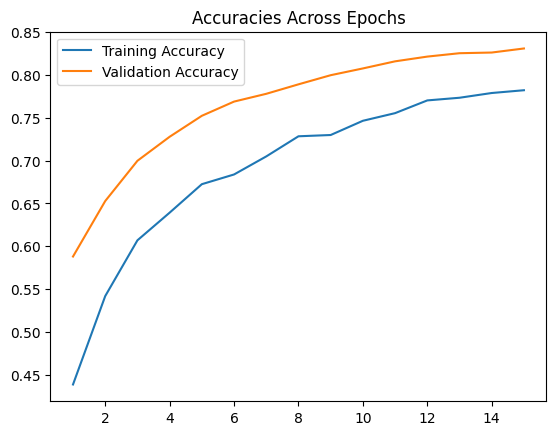

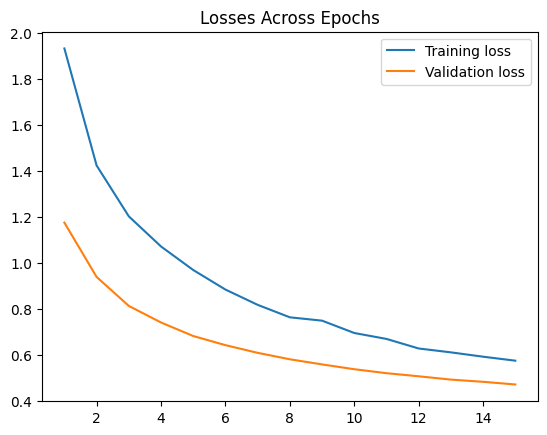

In [ ]:
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracies Across Epochs')
plt.legend()
plt.figure()
## saved as epochs_accuracies.png

plt.plot(epoch_range, loss,  label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Losses Across Epochs')
plt.legend()
plt.show()        
## saved as epochs_losses.png



In [ ]:
y_pred = model.predict(train_ds)
print(class_names[np.argmax(y_pred[1])])

232/232 [==============================] - 68s 294ms/step
Lung_Opacity


In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 14

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables)

14

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

model_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=this_model.epoch[-1], batch_size=128, verbose=1, callbacks = [es])

Epoch 15/25
232/232 [==============================] - 123s 508ms/step - loss: 0.3757 - accuracy: 0.8633 - val_loss: 0.2496 - val_accuracy: 0.9092
Epoch 16/25
232/232 [==============================] - 117s 503ms/step - loss: 0.1967 - accuracy: 0.9318 - val_loss: 0.1932 - val_accuracy: 0.9329
Epoch 17/25
232/232 [==============================] - 116s 502ms/step - loss: 0.1292 - accuracy: 0.9556 - val_loss: 0.2121 - val_accuracy: 0.9219
Epoch 18/25
232/232 [==============================] - 117s 504ms/step - loss: 0.0957 - accuracy: 0.9690 - val_loss: 0.2158 - val_accuracy: 0.9258
Epoch 19/25
232/232 [==============================] - 117s 503ms/step - loss: 0.0759 - accuracy: 0.9733 - val_loss: 0.2187 - val_accuracy: 0.9266


In [ ]:
accuracy += model_fine.history['accuracy']
val_accuracy += model_fine.history['val_accuracy']

loss += model_fine.history['loss']
val_loss += model_fine.history['val_loss']

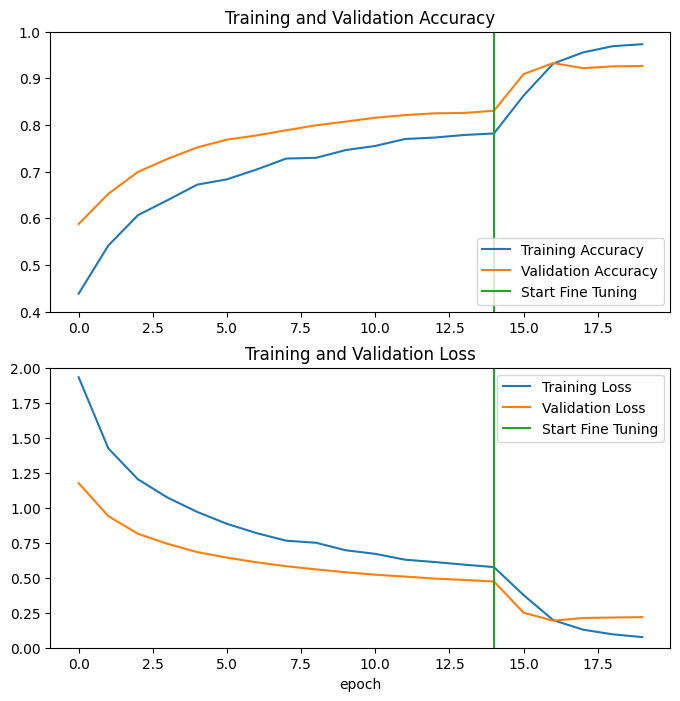

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 6s 274ms/step - loss: 0.2329 - accuracy: 0.9141
Test accuracy : 0.9140625


In [ ]:
np.argmax(y_pred, axis=1)

array([2, 1, 2, ..., 0, 2, 2])

In [ ]:
np.unique(y_pred, axis=1)

array([[1.89870421e-04, 5.37569933e-02, 8.86150151e-02, 8.57438028e-01],
       [5.82610723e-04, 8.59860063e-01, 3.10394932e-02, 1.08517826e-01],
       [5.07740742e-06, 6.41688108e-02, 2.88467645e-03, 9.32941437e-01],
       ...,
       [2.04893835e-02, 9.63771194e-02, 8.52358818e-01, 3.07746381e-02],
       [2.40880903e-03, 8.23356604e-05, 3.40354920e-04, 9.97168481e-01],
       [2.76692547e-02, 1.34935919e-02, 3.35648715e-01, 6.23188376e-01]],
      dtype=float32)

In [ ]:
model.evaluate(val_ds)

80/80 [==============================] - 23s 289ms/step - loss: 0.2187 - accuracy: 0.9266


[0.2186548411846161, 0.9265982508659363]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predIdxs = model.predict(val_ds, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

predIdxs.shape
#print(classification_report(train_ds.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

80/80 [==============================] - 23s 289ms/step


(2534,)

In [ ]:
from sklearn.metrics import accuracy_score

#np.argmax(y_pred, axis=1)

#['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'] (0,1,2,3)

#WRITE A LOOP AND STORE THE BATCH LABELS TO GET THE Y TRUE VALUES

#for image_batch, labels_batch in train_ds:
#  print(image_batch.shape)
#  print(labels_batch.shape)
#  break

#print("Accuracy: ", accuracy_score(y_pred))

print(y_pred.shape)
print(labels.shape)

(7408, 4)
(32, 4)


In [ ]:
import tensorflow.math
from tensorflow.math import confusion_matrix

tensorflow.math.confusion_matrix(labels = labels, predictions = np.argmax(y_pred, axis=1))

InvalidArgumentError: ignored

In [ ]:
x = confusion_matrix(np.argmax(y_val, axis=0),np.argmax(y_pred, axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
#model.score(val_ds)
#scikit learn functions for F1, precision, etc

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_val))
correct_prediction

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
accuracy